# Data interpolation

In [1]:
%matplotlib inline

import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from scipy.signal import find_peaks, peak_widths
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

In [2]:
FACE_MESH = pd.read_csv('faceMesh/face_mesh.csv')

def landmarks_mapper(video: str, cleansed_data: bool):
    
    OPENFACE_LANDMARKS = [i for i in range(17, 68)]
    
    if cleansed_data:
        OPENFACE_DIR = 'openFace/processed_cleansed/'
        MEDIAPIPE_DIR = 'mediaPipe/processed_cleansed/'
    else:
        OPENFACE_DIR = 'openFace/processed/'
        MEDIAPIPE_DIR = 'mediaPipe/processed/'
        
    of_df = pd.read_csv(OPENFACE_DIR + video + '_openface.csv')
    mp_df = pd.read_csv(MEDIAPIPE_DIR + video + '_mediapipe.csv')
    
    final_df = of_df['frame'] # initialize the final dataframe
    for i, landmark in enumerate(OPENFACE_LANDMARKS):

        mask = (FACE_MESH['openFace_landmark'] == landmark) # group the mediapipe landmarks by the openface landmark

        tmp1_df = of_df[[f'x_{landmark}', f'y_{landmark}']] # select the columns from the openface dataframe
        tmp1_df.columns = [f'openface_x_{landmark}', f'openface_y_{landmark}'] # rename the columnsk
        
        mediaPipe_landmarks_X = ['x_'+str(ID) for ID in FACE_MESH[mask].id] # collect the X coordinate
        mediaPipe_landmarks_Y = ['y_'+str(ID) for ID in FACE_MESH[mask].id] # collect the Y coordinate
        
        tmp2_df = pd.DataFrame({f'mediapipe_x_{landmark}':mp_df[mediaPipe_landmarks_X].mean(axis=1),
                                f'mediapipe_y_{landmark}':mp_df[mediaPipe_landmarks_Y].mean(axis=1)})
        
        final_df = pd.concat([final_df, tmp1_df, tmp2_df], axis=1)
        
    return final_df

In [3]:
def mse(df: pd.DataFrame):
    
    lndmk_mse = []
    for i in range(17, 68):
        
        x_mse = mean_squared_error(df[f'mediapipe_x_{i}'].to_numpy(), df[f'openface_x_{i}'].to_numpy())
        y_mse = mean_squared_error(df[f'mediapipe_y_{i}'].to_numpy(), df[f'openface_y_{i}'].to_numpy())
        lndmk_mse.append((x_mse+y_mse)/2)
    
    video_mse = np.mean(lndmk_mse)
    
    return video_mse

### Peak detection

In [67]:
video_name = '50_50_4'
mapped_landmarks_df = landmarks_mapper(video_name, cleansed_data=True)
window_size = (lambda seconds: round(24*seconds))(0.2)
windows = mapped_landmarks_df.rolling(window=window_size, center=True) # centralized sliding window
windowized_mse = preprocessing.normalize([[mse(window) for window in windows]], norm='max').flatten() # normalize values between 0 and 1

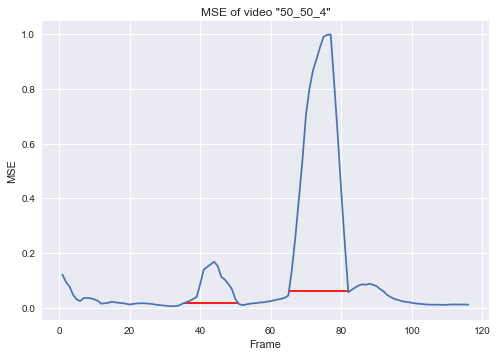

In [68]:
plt.style.use('seaborn')
plt.plot(mapped_landmarks_df.frame, windowized_mse)
plt.title(f'MSE of video "{video_name}"')
plt.xlabel('Frame')
plt.ylabel('MSE')

peaks, _ = find_peaks(windowized_mse, height=0.15)
widths = peak_widths(windowized_mse, peaks, rel_height=0.95)

for frames in widths[2:]:
    frames += mapped_landmarks_df.frame.iloc[0] # add the starting frame of the video
    
plt.plot(peaks, windowized_mse[peaks], 'x')
plt.hlines(*widths[1:], color="red")
plt.show()

### Interpolation

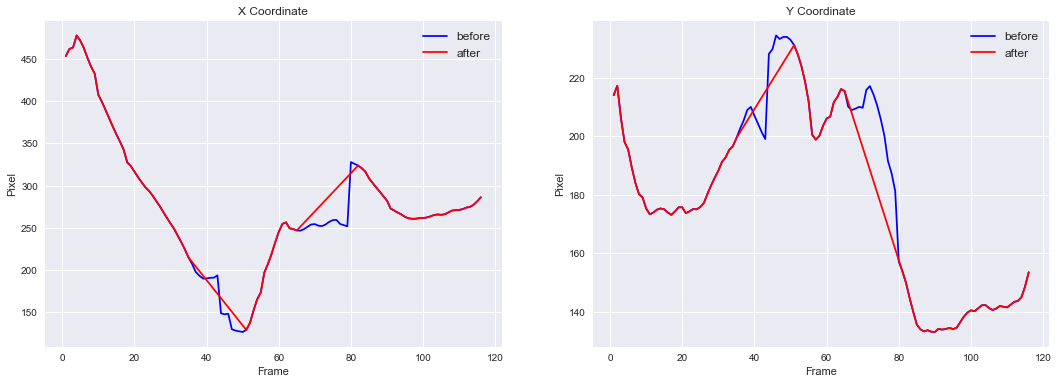

In [69]:
openface_df = pd.read_csv(f'openFace/processed_cleansed/{video_name}_openface.csv')

_, axes = plt.subplots(1, 2, figsize=(18,6))
axes = axes.flatten()

axes[0].set(title='X Coordinate', xlabel='Frame', ylabel='Pixel')
axes[1].set(title='Y Coordinate', xlabel='Frame', ylabel='Pixel')

axes[0].plot(openface_df.frame, openface_df.x_27, color='blue', label='before')
axes[1].plot(openface_df.frame, openface_df.y_27, color='blue', label='before')

starting_points = widths[2]
ending_points = widths[3]

for peak_points in zip(starting_points, ending_points):
    
    start = round(peak_points[0])
    end = round(peak_points[1])
    peak_frames = [frame for frame in range(start, end)]
    for i in range(68):
        openface_df.loc[start:end-2, f'x_{i}'], openface_df.loc[start:end-2, f'y_{i}'] = np.nan, np.nan
    openface_df.interpolate(method='linear', axis=0, inplace=True)
      
axes[0].plot(openface_df.frame, openface_df.x_27, color='red', label='after')
axes[1].plot(openface_df.frame, openface_df.y_27, color='red', label='after')

axes[0].legend(fontsize='large')
axes[1].legend(fontsize='large')
plt.show()

### Visualization of the interpolated landmarks

In [70]:
def draw_landmark(image, landmarks_df, frame):
    
    x_regex_pat = re.compile(r'^x_[0-9]+$')
    y_regex_pat = re.compile(r'^y_[0-9]+$')
    
    x_locs = landmarks_df.columns[landmarks_df.columns.str.contains(x_regex_pat)]
    y_locs = landmarks_df.columns[landmarks_df.columns.str.contains(y_regex_pat)]
    
    image.flags.writeable = True
    
    x_i = landmarks_df[x_locs].iloc[frame]
    y_i = landmarks_df[y_locs].iloc[frame]
    for i in range(68):
        x, y = round(x_i[i]), round(y_i[i])
        image[y,x-1] = [0,255,0]
        image[y,x+1] = [0,255,0]
        image[y-1,x] = [0,255,0]
        image[y+1,x] = [0,255,0]
        
    return

In [71]:
baseDir = 'dataset/ElderReact_Data/ElderReact_train/'

cap = cv2.VideoCapture(baseDir + video_name + '.mp4')

frame = -openface_df.frame.iloc[0]
while cap.isOpened():
    success, image = cap.read()
    if not success: break
    if frame < cap.get(cv2.CAP_PROP_FRAME_COUNT)-1: frame+=1
        
    image.flags.writeable = False
    draw_landmark(image, openface_df, frame)
        
    cv2.imshow(f'{video_name}', image)
    cv2.waitKey(20)
    
cv2.destroyAllWindows()

### Creation of some videos

In [27]:
def interpolate(video):
    
    mapped_landmarks_df = landmarks_mapper(video, cleansed_data=True)
    window_size = (lambda seconds: round(24*seconds))(0.2)
    windows = mapped_landmarks_df.rolling(window=window_size, center=True) # centralized sliding window
    windowized_mse = preprocessing.normalize([[mse(window) for window in windows]], norm='max').flatten() # normalize values between 0 and 1

    peaks, _ = find_peaks(windowized_mse, height=0.15)
    widths = peak_widths(windowized_mse, peaks, rel_height=0.95)
    for frames in widths[2:]:
        frames += mapped_landmarks_df.frame.iloc[0] # add the starting frame of the video

    openface_df = pd.read_csv(f'openFace/processed_cleansed/{video}_openface.csv')
    starting_points = widths[2]
    ending_points = widths[3]

    for peak_points in zip(starting_points, ending_points):

        start = round(peak_points[0])
        end = round(peak_points[1])
        peak_frames = [frame for frame in range(start, end)]
        
        for i in range(68):
            openface_df.loc[start:end-2, f'x_{i}'], openface_df.loc[start:end-2, f'y_{i}'] = np.nan, np.nan
        openface_df.interpolate(method='linear', axis=0, inplace=True)
        
    return openface_df

In [28]:
videos = ['gta1_1', 'david_bowie_109', 'david_bowie_13', 'fatality_9', 'gta2_26', 'play_lastofus_202', 'happy_wheels_97']

baseDir = 'dataset/ElderReact_Data/ElderReact_train/'
out_dir = 'openFace/interpolated_videos/'

for video in videos:

    openface_df = interpolate(video)
    cap = cv2.VideoCapture(baseDir + video + '.mp4')

    frame = -openface_df.frame.iloc[0]
    unknown_size = True
    while cap.isOpened():
        success, image = cap.read()
        if not success: break
        if frame < cap.get(cv2.CAP_PROP_FRAME_COUNT)-1: frame+=1

        image.flags.writeable = False
        draw_landmark(image, openface_df, frame)

        height, width, layers = image.shape
        size = (width,height)

        if unknown_size:
            out = cv2.VideoWriter(out_dir + video + '.avi', cv2.VideoWriter_fourcc(*'XVID'), 24, size, isColor=True)
            unknown_size = False

        out.write(image)

    cap.release()
    out.release()

### Creation of the interpolated dataframes

In [ ]:
for video in os.listdir('dataset/ElderReact_Data/ElderReact_train/'):
    
    video_name = video[:-4]
    #interpolate(video_name).to_csv(f'openFace/processed_interpolated/{video_name}_openface.csv')
    interpolate(video_name).to_csv(f'mediaPipe/processed_interpolated/{video_name}_mediapipe.csv')